<img src="../images/bikes_banner.jpg" width="1000" />

# <span style="color:#37535e">Bicycle Share Usage Prediction Modeling</span>
<blockquote><span style="color:#3b748a">Relay Bike Share is the City of Atlanta’s bike share operator. With 500 “smart bikes” and over 70 stations across the city, Relay seeks to be a healthy and enjoyable transportation solution.</span></blockquote>

<span style="color:#3b748a">I want to predict where and when will the bikes be used so we know many should be put at a station on a particular day? In addition, it would be interesting to predict how far a bike at a station might travel on a given day in order to balancing bikes for even usage.</span>

<span style="color:#3b748a">Trip data for the past year can be found at 
<a href="http://relaybikeshare.com/system-data/">http://relaybikeshare.com/system-data/</a>.</span>

## <span style='color:#3b748a'>Table of contents</span>
* <a href="#step1"><span style='color:#4095b5'>I. Define the problem.</span></a>
* <a href="#step2"><span style='color:#4095b5'>II. Obtain the data.</span></a>
* <a href="#step3"><span style='color:#4095b5'>III. Explore the data.</span></a>
* <a href="#step4"><span style='color:#4095b5'>IV. Model the data.</span></a>
* <a href="#step5"><span style='color:#4095b5'>V. Evaluate the model.</span></a>
* <a href="#step6"><span style='color:#4095b5'>VI. Answer the problem.</span></a>


<hr>
 <a name="step1"></a>
 ## <span style="color:#37535e">I. Define the problem</span>
 
<span style='color:#3b748a'>I propose to use regression modeling to determine how many bikes a rack needs to have at the start of the day so that it will not be empty. I also hope to investigate different methods of shuffling bikes so that they will get even amounts of usage.</span>

<a name="step2"></a>
## <span style="color:#37535e">II. Obtain the data.</span>

<ul>
    <li><span style='color:#3b748a'>6 cities with possibility of 2 more: Atlanta, Boston, Chicago, LA, Philly, and SF with possibility for DC and NYC. Only one year of data for now (Sep 2017 - Aug 2018 or Jul 2017 - Jun 2018), but we have more for some of the cities.</span></li>
    <li><span style='color:#3b748a'>Weather data scraped using BeautifulSoup from Weather Underground for all 8 cities for 2017 &amp; 2018 but can easily scrape more. Daylight data scraped as well.</span></li>
</ul>

In [1]:
# Let's get the administrative stuff done first
# import all the libraries and set up the plotting

import pandas as pd
import numpy as np
from datetime import datetime,timedelta

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# GnBu_d
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### <span style='color:#3b748a'>Check the data</span>

In [2]:
# Check which numeric columns are missing values

def check_data(df):
    s = df.shape

    # Check for null values
    null_data = df.isnull().sum()
    null_data_count = sum(df.isnull().sum())
    print("Rows: {}\t Cols: {}\t NaNs: {}".format(s[0],s[1],null_data_count))
    if  null_data_count > 0:
        print("Columns with NaN: {}".format(list(null_data[null_data > 0].index)))

    return

### <span style='color:#3b748a'>Bike share data</span>
<span style='color:#4095b5'>Each row (observation) data describes each rental. Each rental includes a starting place and time, a ending place and time, as well as distance, user, and bike information. </span>

### <span style='color:#3b748a'>Weather data</span>
<span style='color:#4095b5'>Each row (observation) data describes one day of weather. The information includes: date, temperature, dew, humidity, sea air pressure, visibility, precipitation, and "events". </span>

### <span style='color:#3b748a'>Daylight data</span>
<span style='color:#4095b5'>Each row (observation) data describes the number of hours of daylight for one day. </span>

In [3]:
# NOTE: The trips_all.csv for bos, chi, phl, sf are TOO big to push to the GitHub repository
# NOTE: I don't have cleaned trip data for DC and NYC yet

city_code = 'atl'
cities = { 
    'atl' : {
        'name' : 'Atlanta',
        'peak' : 195,
        'drop_features' : {'Start Date', 'Month', 'DayOfYear', 'Week', 'Year', 'Date', 'wind_avg'}
    },
    'bos' : {
        'name' : 'Boston',
        'peak' : 205,
        'drop_features' : {'Start Date', 'Month', 'DayOfYear', 'Week', 'Date'}
    },
    'chi' : {
        'name' : 'Chicago',
        'peak' : 206,
        'drop_features' : {'Start Date', 'Month', 'DayOfYear', 'Week', 'Date'}
    },
    'la' : {
        'name' : 'Los Angeles',
        'peak' : 210,
        'drop_features' : {'Start Date', 'Month', 'DayOfYear', 'Year'}
    },
    'phl' : {
        'name' : 'Philadelphia',
        'peak' : 220,
        'drop_features' : {'Start Date', 'Month'}
    },
    'sf' : {
        'name' : 'San Francisco',
        'peak' : 177,
        'drop_features' : {'Start Date', 'Month'}
    }
}


In [4]:
# Read and clean data
df_bikes = pd.DataFrame()
df_weather = pd.DataFrame()
df_daylight = pd.DataFrame()

# Bike trips for city
df = pd.read_csv('../data/' + city_code + '/trips_all.csv')
df['City'] = city_code
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])
df['Duration'] = pd.to_timedelta(df['Duration'], unit='m')
# Make duration as total minutes
df['Duration'] = (df['Duration'].dt.total_seconds()/60)

df_bikes = df_bikes.append(df)

# Weather for city
df = pd.read_csv('../data/' + city_code + '/weather.csv')
df['City'] = city_code
df.drop(['dew_avg', 'dew_max', 'dew_min', 'hum_max', 'hum_min', 'sea_avg', 'sea_max', 'sea_min',
         'temp_max', 'temp_min', 'vis_avg', 'vis_max', 'vis_min', 'wind_max', 'wind_unk'], 
        axis=1, inplace=True)
df['prec'].replace(to_replace='T',value = '0.01', inplace=True)
df['prec'] = df['prec'].astype(float)
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'Start Date'}, inplace=True)

df_weather = df_weather.append(df)

# Daylight for city
df = pd.read_csv('../data/' + city_code + '/daylight.csv')
df['City'] = city_code

# Make duration as total minutes
df['Daylight'] = pd.to_timedelta(df['Daylight'], unit='m')
df['Daylight'] = (df['Daylight'].dt.total_seconds()/60)
df['Date'] = pd.to_datetime(df['Date'])
df.rename(columns={'Date': 'Start Date'}, inplace=True)

df_daylight = df_daylight.append(df)


<a name="step3"></a>
## <span style="color:#37535e">III. Explore the data.</span>

<ul>
    <li><span style='color:#3b748a'>Check the data read in from the csv files.</span></li>
</ul>

In [5]:
check_data(df_bikes)
print(df_bikes.columns)
df_bikes.dtypes

Rows: 103706	 Cols: 14	 NaNs: 0
Index(['Start Hub', 'Start Latitude', 'Start Longitude', 'Start Date',
       'Start Time', 'End Hub', 'End Latitude', 'End Longitude', 'End Date',
       'End Time', 'Bike Name', 'Distance [Miles]', 'Duration', 'City'],
      dtype='object')


Start Hub                   object
Start Latitude             float64
Start Longitude            float64
Start Date          datetime64[ns]
Start Time          datetime64[ns]
End Hub                     object
End Latitude               float64
End Longitude              float64
End Date            datetime64[ns]
End Time            datetime64[ns]
Bike Name                   object
Distance [Miles]           float64
Duration                   float64
City                        object
dtype: object

In [6]:
check_data(df_weather)
print(df_weather.columns)
df_weather.dtypes

Rows: 647	 Cols: 7	 NaNs: 0
Index(['Start Date', 'events', 'hum_avg', 'prec', 'temp_avg', 'wind_avg',
       'City'],
      dtype='object')


Start Date    datetime64[ns]
events                object
hum_avg                int64
prec                 float64
temp_avg               int64
wind_avg               int64
City                  object
dtype: object

In [7]:
check_data(df_daylight)
print(df_daylight.columns)
df_daylight.dtypes

Rows: 730	 Cols: 3	 NaNs: 0
Index(['Start Date', 'Daylight', 'City'], dtype='object')


Start Date    datetime64[ns]
Daylight             float64
City                  object
dtype: object

<a name="step4"></a>
## <span style="color:#37535e">IV. Model the data.</span>

### <span style='color:#3b748a'>First model</span>
<span style='color:#4095b5'>Let's predict how many rides a day (or total distance or total duration) based on day of week and weather.</span>

### <span style='color:#3b748a'>Feature engineering</span>
<ul>
    <li><span style='color:#4095b5'>Use Groupby to create a DataFrame for daily trip data, using columns: Start Date, City, Total Duration, Total Duration, and Total Trips.</span></li>
    <li><span style='color:#4095b5'>Merge the trip data with the weather data.</span></li>
    <li><span style='color:#4095b5'>Add day of the week and week of the year.</span></li>
    <li><span style='color:#4095b5'>Add day of the week and week of the year.</span></li>
    <li><span style='color:#4095b5'>Create a "peak" variable to capture more of the cyclic usage.</span></li>
    <li><span style='color:#4095b5'>Make dummies</span></li>
</ul>

In [8]:
# Drop unnecssary columns
cols_drop = ['Start Hub', 'Start Latitude', 'Start Longitude', 
       'Start Time', 'End Hub', 'End Latitude', 'End Longitude', 'End Date',
       'End Time', 'Bike Name']
cols_drop = list(set(df_bikes.columns) & set(cols_drop))
             
df_bikes.drop(cols_drop, axis=1, inplace=True)
df_weather.drop(['events'], axis=1, inplace=True)

In [9]:
# Group the data frame by month and item and extract a number of stats from each group
# Used https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

df_daily = df_bikes.groupby(['Start Date','City'], as_index=False).agg({
    "Duration": ['sum', 'count'],
    "Distance [Miles]" : ['sum']
})

df_daily.columns = ["_".join(x) for x in df_daily.columns.ravel()]
df_daily.rename(columns={
    'Start Date_' : 'Start Date',
    'City_' : 'City',
    'Duration_count': 'Trips', 
    'Duration_sum' : 'Total Duration', 
    'Distance [Miles]_sum' : 'Total Distance'
}, inplace=True)

 #### <span style='color:#4095b5'>Merge daily, weather, and daylight</span>

In [10]:
# Merge on city and date
df = pd.merge(df_daily, df_weather, on = ['Start Date', 'City'], how = 'left')
df = pd.merge(df, df_daylight, on = ['Start Date', 'City'], how = 'left')

 #### <span style='color:#4095b5'>Add all parts of a date to the merged dataframe</span>

In [11]:
df['Date'] = df['Start Date'].astype(int)
df['Day'] = (df['Start Date'].dt.strftime('%w'))
df['DayOfYear'] = (df['Start Date'].dt.strftime('%-j')).astype(int)
df['Week'] = (df['Start Date'].dt.strftime('%W')).astype(int)
df['Month'] = (df['Start Date'].dt.strftime('%-m')).astype(int)
df['Year'] = (df['Start Date'].dt.strftime('%Y')).astype(int)

 #### <span style='color:#4095b5'>Distance from "midsummer" peak </span>
 <span style='color:#4095b5'>This date may vary by city.</span>

In [12]:
# How many days in year to peak
peak = cities[city_code]['peak']
df['Peak'] = np.minimum(abs(df['DayOfYear'] - peak), abs(365+peak-df['DayOfYear']))

 #### <span style='color:#4095b5'>Make dummies</span>

In [13]:
# Make dummies
print("Before make dummies: {}".format(df.shape))
df = pd.get_dummies(df)
print("After make dummies: {}".format(df.shape))
df.columns

Before make dummies: (365, 17)
After make dummies: (365, 23)


Index(['Start Date', 'Total Duration', 'Trips', 'Total Distance', 'hum_avg',
       'prec', 'temp_avg', 'wind_avg', 'Daylight', 'Date', 'DayOfYear', 'Week',
       'Month', 'Year', 'Peak', 'City_atl', 'Day_0', 'Day_1', 'Day_2', 'Day_3',
       'Day_4', 'Day_5', 'Day_6'],
      dtype='object')

### <span style='color:#3b748a'>The MASSIVE Pipeline</span>
<ul>
    <li><span style='color:#4095b5'>The Pipeline function takes a set of features and a model and runs grid search over their parameters on the train/test data for the specified model.</span></li>
    <li><span style='color:#4095b5'>Adjustment of the parameter ranges is not automated at this time. Each time it runs, we check to see if a parameter bound has been hit and adjust the value ranges.</span></li>
    <li><span style='color:#4095b5'>The function returns information about the best model, but not the model itself. Perhaps to be included in the future.</span></li>
</ul>

In [14]:
def run_pipline(items, X_train, X_test, y_train, y_test):

    # Add a pipe, add a param !
    pipe_items = {
        'ss' : StandardScaler(),
        'pf' : PolynomialFeatures(),
        'pca' : PCA(),

        'lr' : LinearRegression(),
        'rd' : Ridge(),
        'la' : Lasso(),
        'en' : ElasticNet(), 
        'gr' : GaussianProcessRegressor(),
        'rf' : RandomForestRegressor(),
        'gb' : GradientBoostingRegressor(),
        'ab' : AdaBoostRegressor(),
        'svm' : SVR(),
        'knn' : KNeighborsRegressor(),
        
        'lgr' : LogisticRegression(),
        'rfc' : RandomForestClassifier(),
        'gbc' : GradientBoostingClassifier(),
        'abc' : AdaBoostClassifier(),
        'svc' : SVC(),
        'knnc' : KNeighborsClassifier()

    }

    # Include at least one param for each pipe item
    param_items = {
        'ss' : {
            'ss__with_mean' : [False]
        },
        'pf' : {
            'pf__degree' : [2]
        },
        'pca' : {
            'pca__n_components' : [10,11, 12]
        },
        'lr' : {
            'lr__n_jobs' : [1]
        },
        'rd' : {
             'rd__alpha' : [1.1, 1.3, 1.5, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.5, 3.0, 4.0, 4.6, 4.8, 5.0, 6.0, 6.5, 7.0, 7.5, 8.0, 9.5, 
                            12.0, 15.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 
                           70.0] # ATL 8.0, BOS 1.5
        },
        'la' : {
             'la__alpha' : [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.7, 
                            3.0, 7.8, 8.0, 8.5, 
                            10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0 ],
             'la__max_iter' : [100, 250, 500, 1000] # ATL 100
        },
        'en' : {
             'en__alpha' : [0.04, 0.08, 0.1, 0.2, 0.3, 1.0, 1.5, 1.8, 1.9, 2.0, 2.2, 2.5, 3.0],
             'en__l1_ratio' : [0.4, 0.6, 0.8, 1, 1.2],
             'en__max_iter' : [250, 500, 750, 1000]
        },

        'gr' : {
            'gr__alpha' : [1, 0.1]
        },
        'rf' : {
            'rf__n_estimators' : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
                                  23, 24, 25, 26, 27, 28, 29, 30],
            'rf__criterion' : ['mse', 'mae']
        },
        'gb' : {
            'gb__n_estimators' : [325, 326, 327, 328, 329, 330, 331, 332, 333, 334],
            'gb__loss' : ['ls', 'lad', 'huber', 'quantile']
        },
        'ab' : {
            'ab__n_estimators' : [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
        },
        'svm' : {
            'svm__kernel' : ['linear','poly']
        },
        'knn' : {
            'knn__n_neighbors' : [2, 3, 4, 5, 6, 7, 8, 9, 10] 
        },
        'lgr' : {
            'lgr__C' : [.04, .05, .06],
            'lgr__penalty' : ['l1','l2']
        },
        'rfc' : {
            'rfc__n_estimators' : [7, 8, 9, 10]
        },
        'gbc' : {
            'gbc__n_estimators' : [35, 40, 45]
        },
        'abc' : {
            'abc__n_estimators' : [80, 90, 100]
        },
        'svc' : {
            'svc__kernel' : ['linear','poly']
        },
        'knnc' : {
            'knnc__n_neighbors' : [35, 40, 45, 50]
        }

    }

    # Create the parameters for GridSearch
    params = dict()
    for i in items:
        for p in param_items[i]:
            params[p] = param_items[i][p]

    # Create the pipeline
    pipe_list = [(i,pipe_items[i]) for i in items]
    print("Using:")
    for p in pipe_list:
        print("\t" + str(p[1]).split('(')[0])
    pipe = Pipeline(pipe_list)

    # Grid search
    gs = GridSearchCV(pipe, param_grid=params, verbose=1)
    gs.fit(X_train, y_train)

    # Print the results
    train_params = gs.best_params_
    train_score = gs.best_score_
    y_test_hat = gs.predict(X_test)
    test_score = gs.score(X_test, y_test)

    for k in train_params:
        print("{}: {}".format(k,train_params[k]))

    print("Train score: {} Test score {}".format(train_score, test_score))
    print("")

    return train_score, test_score, y_test_hat, train_params

### <span style='color:#3b748a'>Prepare for REGRESSION to predict # trips based on day of week, week of year, dylight hours, and weather.</span>
<ul>
    <li><span style='color:#4095b5'>Use a subest of columns.</span></li>
    <li><span style='color:#4095b5'>Do a train/test split on the data.</span></li>
</ul>

In [15]:
# Let's start with a few features
X_cols = list(df.columns)
X_cols.remove('Trips')
X_cols.remove('Total Duration')
X_cols.remove('Total Distance')
# X_cols.remove('Daylight')
# X_cols.remove('Peak')
# X_cols.remove('Month')
# X_cols.remove('DayOfYear')
# X_cols.remove('Week')
# X_cols.remove('Year')
# X_cols.remove('Date')
# X_cols.remove('prec')
# X_cols.remove('wind_avg')
# X_cols.remove('temp_avg')
# X_cols.remove('hum_avg')
remove = list(cities[city_code]['drop_features'])
for r in remove:
    X_cols.remove(r)
    
print(X_cols)

# Target variable
y_trips = df['Trips'].values
X = df[X_cols]  

['hum_avg', 'prec', 'temp_avg', 'Daylight', 'Peak', 'City_atl', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']


In [16]:
# Test/train split of "full training" data
X_train, X_test, y_train, y_test = train_test_split(X, y_trips, random_state=42)

### <span style='color:#3b748a'>Call the pipeline to use REGRESSION to predict the number of trips for a given day</span>
<ul>
    <li><span style='color:#4095b5'>Choose a regression model.</span></span></li>
    <li><span style='color:#4095b5'>Use <span style="font-family:monospace">StandardScaler</span>.</span></li>
    <li><span style='color:#4095b5'>Update params values based on grid search and repeat (not automated).</span></li>
</ul>

In [17]:
# Regression models
# 'ss' : StandardScaler(),
# 'pf' : PolynomialFeatures(),
# 'lr' : LinearRegression(),
# 'rd' : Ridge(),
# 'la' : Lasso(),
# 'en' : ElasticNet(), 
# 'gr' : GaussianProcessRegressor(),
# 'rf' : RandomForestRegressor(),
# 'gb' : GradientBoostingRegressor(),
# 'ab' : AdaBoostRegressor(),
# 'svm' : SVR(),
# 'knn' : KNeighborsRegressor(),

models = ['lr','rd','la','rf','gb','ab','knn'] # 'en', 'gr', 'svm']
print("Modeling: {}".format(cities[city_code]['name']))
models = ['rf','gb']

model_solns = []
for m in models:
    pipe_items = ['ss', m]
    [train_score, test_score, y_test_hat, best_params] = run_pipline(pipe_items,
                                                            X_train, X_test, 
                                                            y_train, y_test)
    model_solns.append({'model': m, 
                        'train_score': train_score, 'test_score': test_score, 
                        'best_params': best_params, 'y_test_hat' : y_test_hat})
    

Modeling: Atlanta
Using:
	StandardScaler
	RandomForestRegressor
Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:   10.8s finished


rf__criterion: mse
rf__n_estimators: 19
ss__with_mean: False
Train score: 0.7397934366648042 Test score 0.5853574451992052

Using:
	StandardScaler
	GradientBoostingRegressor
Fitting 3 folds for each of 40 candidates, totalling 120 fits
gb__loss: ls
gb__n_estimators: 325
ss__with_mean: False
Train score: 0.7195275526825138 Test score 0.6546059438354298



[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   45.0s finished


### <span style='color:#3b748a'>Let's try PCA?</span>

In [18]:
# Create PCA model
pca = PCA()
pca = pca.fit(X_train)
PCA_train = pca.transform(X_train)
PCA_test = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_
print('Explained variance:            ', var_exp)
cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [9.50734373e-01 3.18914483e-02 1.35713929e-02 3.71642448e-03
 1.57868442e-05 1.29992111e-05 1.24321432e-05 1.21483293e-05
 1.18315746e-05 1.16850152e-05 9.47781200e-06 5.38820943e-37
 1.04309856e-38]
Cumulative explained variance:  [0.95073437 0.98262582 0.99619721 0.99991364 0.99992943 0.99994243
 0.99995486 0.99996701 0.99997884 0.99999052 1.         1.
 1.        ]


In [19]:
# Prepare the pipline

models = ['lr','rd','la','rf','gb','ab','knn'] # 'gr',svm']

model_solns = []
if False:
    for m in models:
        pipe_items = ['ss','pca', m]
        [train_score, test_score, y_test_hat, best_params] = run_pipline(pipe_items,
                                                                X_train, X_test, 
                                                                y_train, y_test)
        model_solns.append({'model': m, 
                            'train_score': train_score, 'test_score': test_score, 
                            'best_params': best_params, 'y_test_hat' : y_test_hat})







<a name="step5"></a>
## <span style="color:#37535e">IV. Evaluate the model.</span>


In [20]:
# Test/train split of "full training" data
X_train, X_test, y_train, y_test = train_test_split(X, y_trips, random_state=42)

pipe = Pipeline([
                ('ss', StandardScaler()),
                ('gb', GradientBoostingRegressor())
            ])
params = { 
    'gb__n_estimators' : [324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334],
    'gb__loss' : ['ls', 'lad', 'huber', 'quantile']
}

gs = GridSearchCV(pipe, param_grid=params, verbose=1)
gs.fit(X_train, y_train)

train_score = gs.best_score_
y_test_hat = gs.predict(X_test)
test_score = gs.score(X_test, y_test)

train_params = gs.best_params_
for k in train_params:
    print("{}: {}".format(k,train_params[k]))

print("Train score: {} Test score {}".format(train_score, test_score))

Fitting 3 folds for each of 44 candidates, totalling 132 fits
gb__loss: ls
gb__n_estimators: 332
Train score: 0.721959656450052 Test score 0.6506210275019166


[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:   40.9s finished


/Users/gwyneth/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


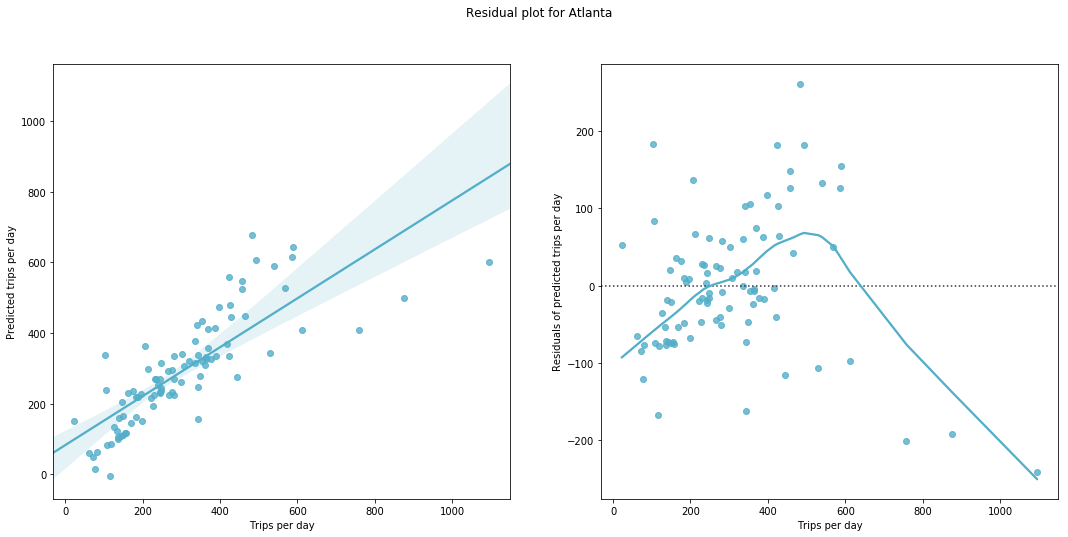

In [21]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
fig.suptitle('Residual plot for ' + cities[city_code]['name'] )

sns.regplot(y_test, y_test_hat, color=colors[3],ax=ax[0])
ax[0].set_xlabel("Trips per day")
ax[0].set_ylabel("Predicted trips per day")
sns.residplot(y_test, y_test_hat, lowess=True, color=colors[3],ax=ax[1])
ax[1].set_xlabel("Trips per day")
ax[1].set_ylabel("Residuals of predicted trips per day");

<hr>
<a name="step6"></a>
## <span style="color:#37535e">V. Answer the question.</span>

